In [1]:
# Run this to load the MNIST dataset
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

In [2]:
# Check the shape of the data to reshape it accordingly
size = X.shape # Check the shape of the data
print(size)

(70000, 784)


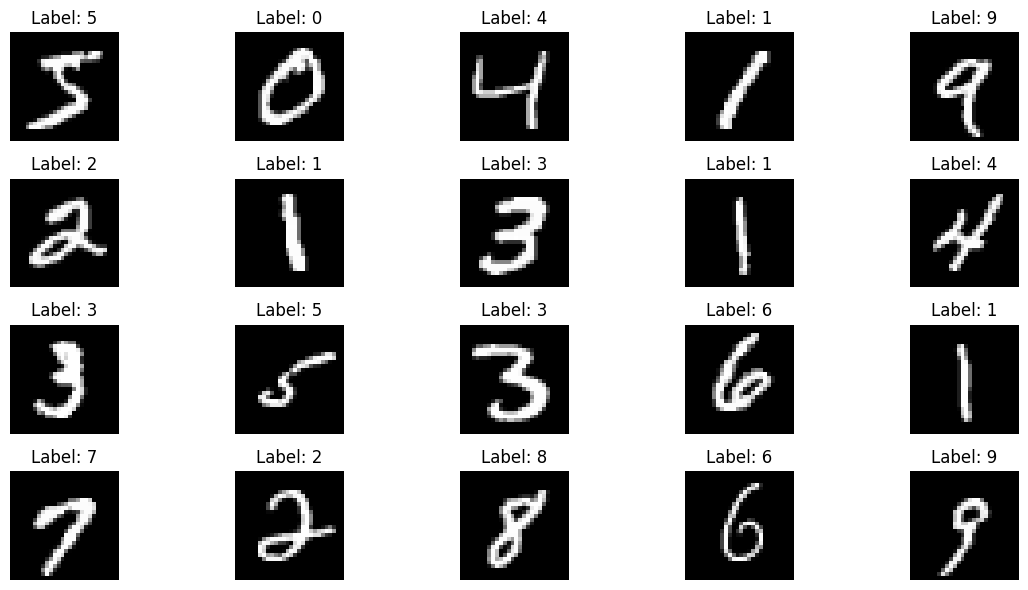

In [3]:
# Normalize the data
X = X / 255.0  # Normalize the data to be between 0 and 1

# Reshape the data
X_images = X.reshape(-1, 28, 28)  # Each digit is 28x28 pixels

# Plot the first 20 digits with their labels
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Label: {y[i]}')
plt.tight_layout()
plt.show()

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [1500]
}
grid_search = GridSearchCV(LogisticRegression(penalty='l1', solver='saga', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

In [5]:
# Train a logistic regression classifier with L1 regularization for sparsity
log_reg = LogisticRegression(random_state=42)
#log_reg = LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [6]:
# Predict on the test set
y_pred = log_reg.predict(X_test)
# Print a classification report to assess accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1343
           1       0.95      0.97      0.96      1600
           2       0.91      0.89      0.90      1380
           3       0.90      0.90      0.90      1433
           4       0.92      0.93      0.92      1295
           5       0.87      0.89      0.88      1273
           6       0.95      0.95      0.95      1396
           7       0.93      0.94      0.94      1503
           8       0.90      0.87      0.88      1357
           9       0.90      0.89      0.90      1420

    accuracy                           0.92     14000
   macro avg       0.92      0.92      0.92     14000
weighted avg       0.92      0.92      0.92     14000



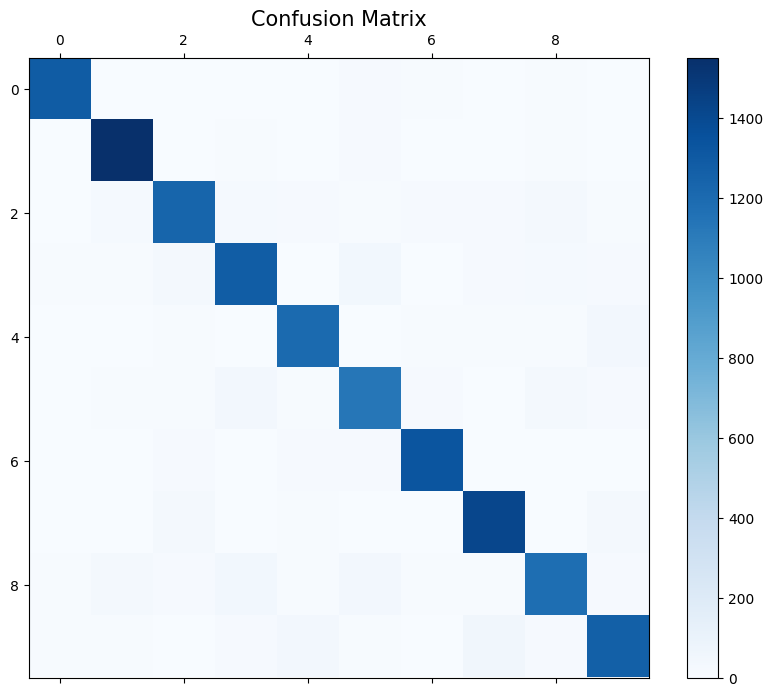

In [7]:
# Plot the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(10, 8))
plt.matshow(confusion_matrix, cmap='Blues', fignum=1)
plt.title('Confusion Matrix', size=15)
plt.colorbar()
plt.show()

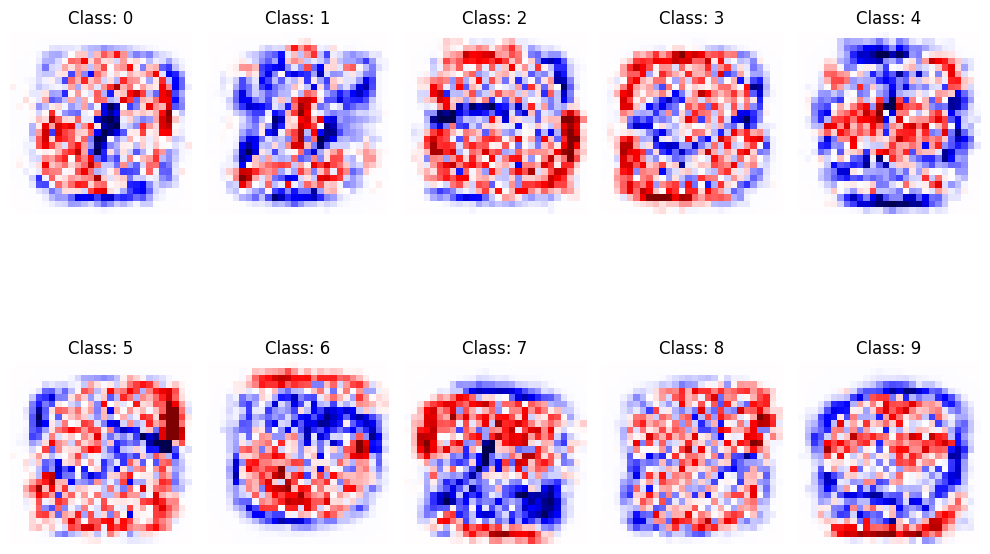

In [8]:
# Get the predicted weights for each class
weights = log_reg.coef_  # Shape will be (10, 784), where 10 is the number of classes

#Red areas indicate pixels that have a high positive weight (strongly indicative of that digit), while blue areas indicate pixels with high negative weights (strongly indicative of not being that digit).
# Plot the classification vectors (weights) for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights[i].reshape(28, 28), cmap='seismic', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'Class: {i}')
plt.tight_layout()
plt.show()

In [9]:
# Apply PCA to the MNIST dataset
pca = PCA()
pca.fit(X)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f'Number of components needed to explain 80% of variance: {n_components_80}')

Number of components needed to explain 80% of variance: 43


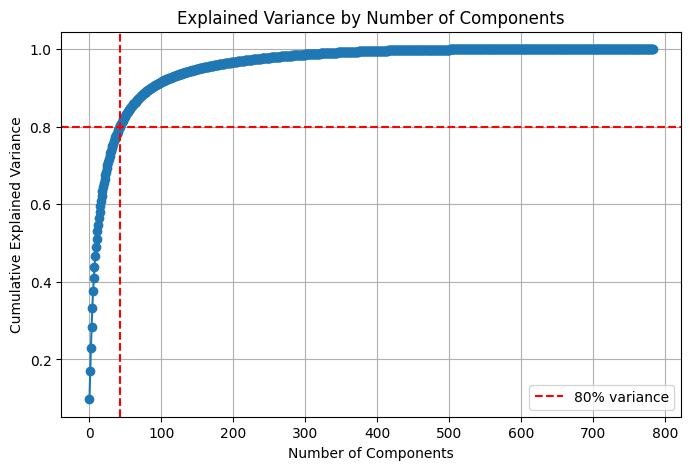

In [10]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% variance')
plt.axvline(x=n_components_80, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.legend()
plt.grid()
plt.show()

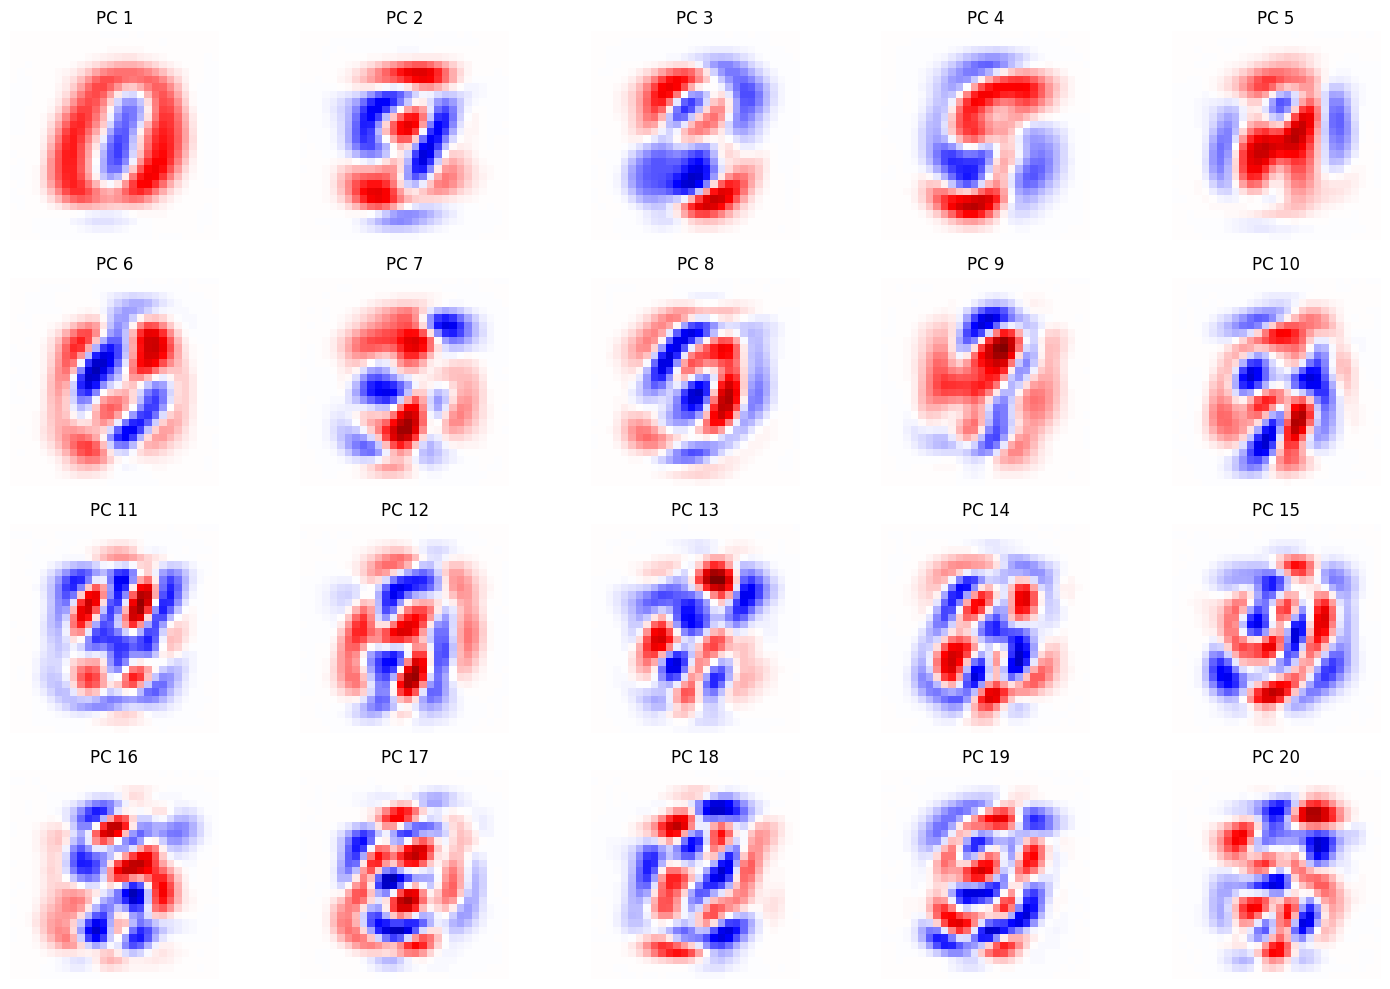

In [11]:
# Fit PCA again with the number of components needed for visualization
pca_20 = PCA(n_components=20)
pca_20.fit(X)

# Plot the loadings for the first 20 principal components
plt.figure(figsize=(15, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pca_20.components_[i].reshape(28, 28), cmap='seismic', vmin=-0.2, vmax=0.2)
    plt.axis('off')
    plt.title(f'PC {i+1}')
plt.tight_layout()
plt.show()

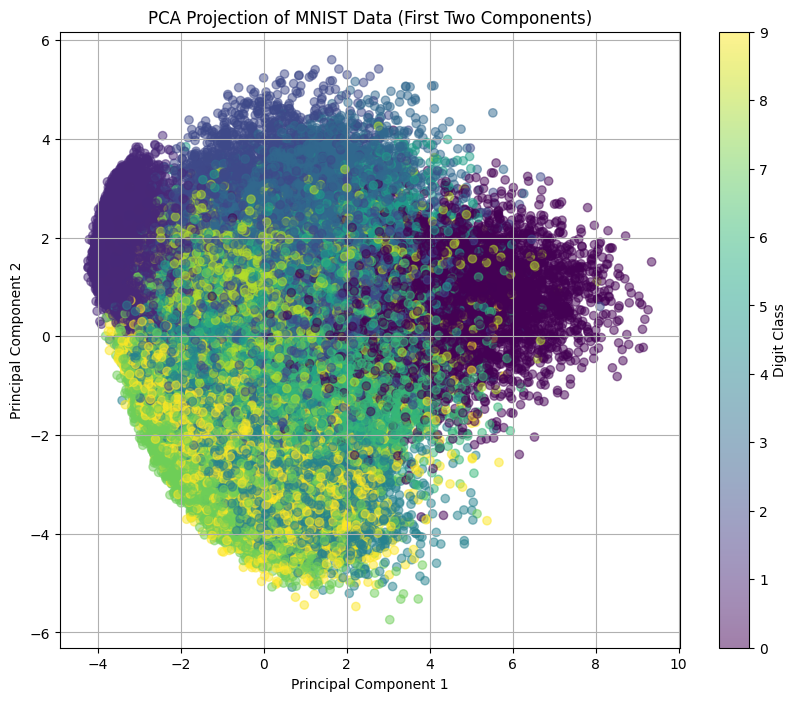

In [12]:
# Reduce dimensionality to 2 components for visualization
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X)

# Plot the first two principal components, colored by class
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=y.astype(int), cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of MNIST Data (First Two Components)')
plt.colorbar(scatter, label='Digit Class')
plt.grid()
plt.show()

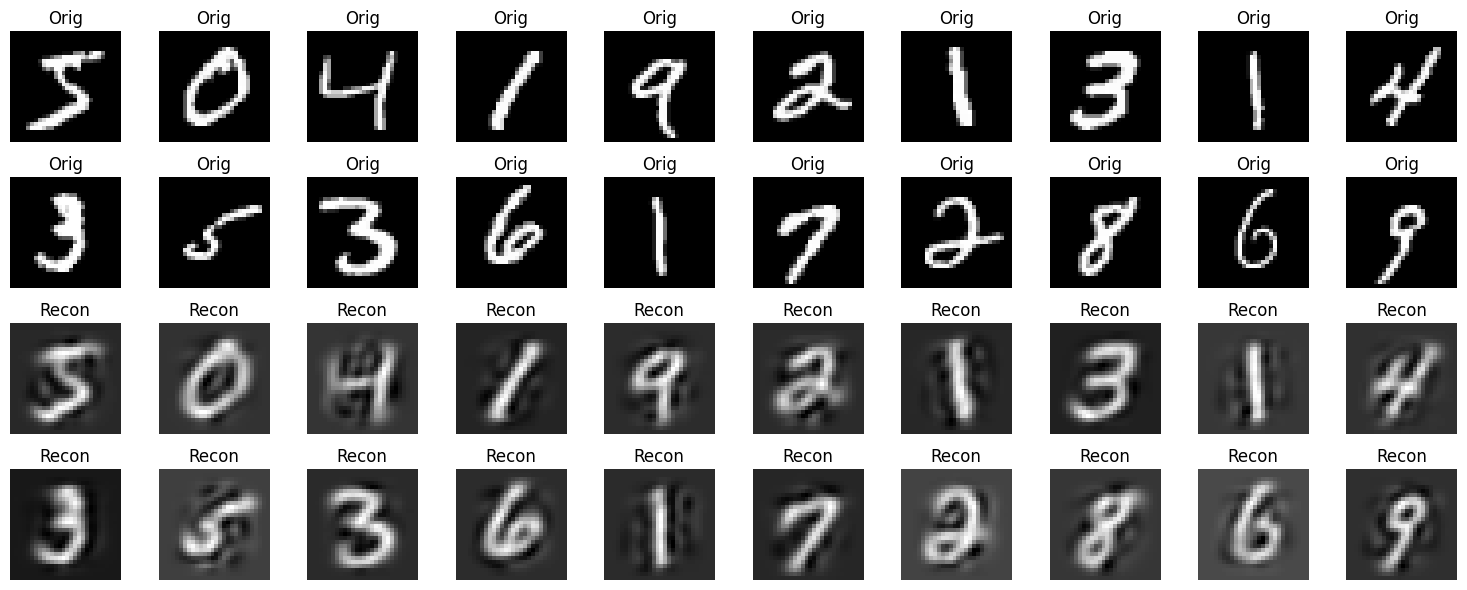

In [13]:
# Fit PCA to reduce to the number of components explaining 80% variance
pca_80 = PCA(n_components=n_components_80)
X_pca_80 = pca_80.fit_transform(X)

# Reconstruct the first 20 digits from the reduced representation
X_reconstructed = pca_80.inverse_transform(X_pca_80)

# Plot the first 20 original and reconstructed digits side by side
plt.figure(figsize=(15, 6))
for i in range(20):
    # Original digit
    plt.subplot(4, 10, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Orig')

    # Reconstructed digit
    plt.subplot(4, 10, i + 21)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Recon')

plt.tight_layout()
plt.show()

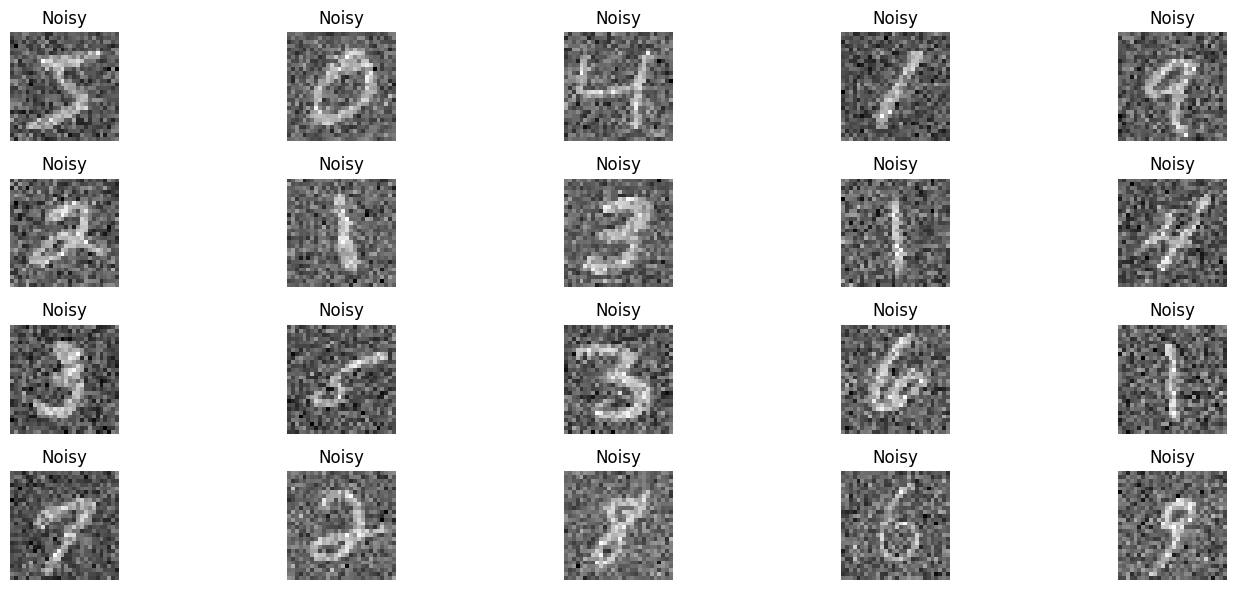

In [20]:
# Generate a noisy copy of the MNIST dataset
noise_factor = 0.3  # Adjust this value to control noise level
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

# Visualize the first 20 noisy digits
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Noisy')
plt.tight_layout()
plt.show()

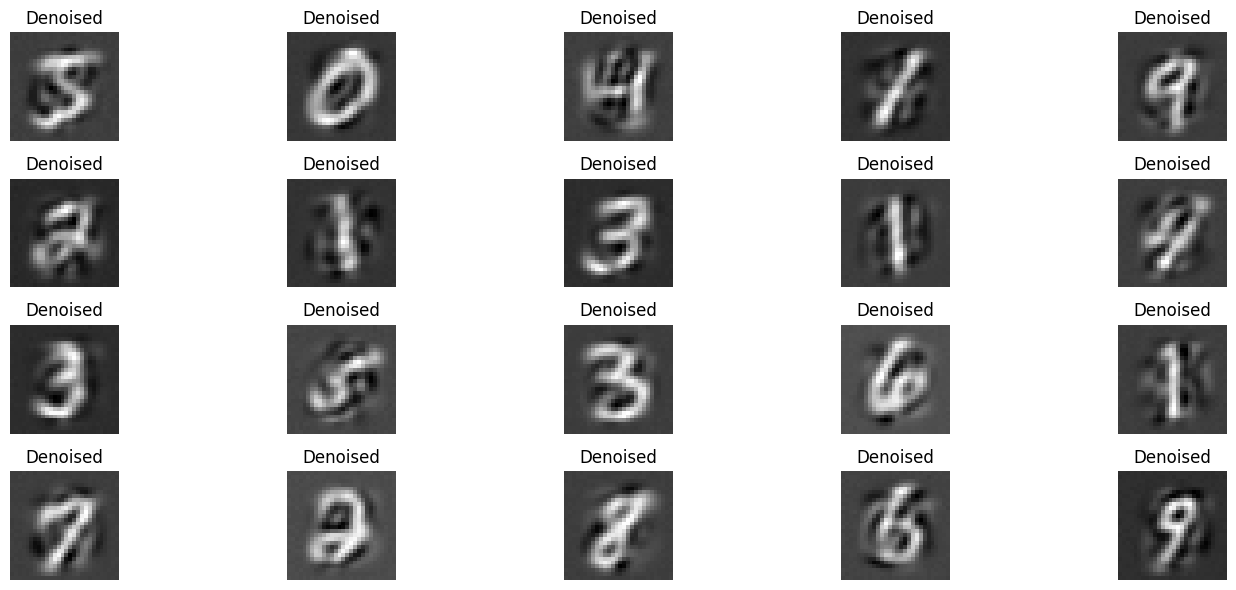

In [21]:
# Fit PCA to reduce dimensionality of the noisy data
pca_denoise = PCA(n_components=n_components_80)  # Use components from earlier step to explain sufficient variance
X_noisy_pca = pca_denoise.fit_transform(X_noisy)

# Reconstruct the digits from the reduced representation
X_denoised = pca_denoise.inverse_transform(X_noisy_pca)

# Visualize the first 20 denoised digits
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_denoised[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Denoised')
plt.tight_layout()
plt.show()